# PCA降维：主成分分析
通过线性变换和舍弃部分信息的方式将现有的多维变量替换为几个聚合变量，同时最大限度地减少了数据的损失

本质上是基变换，使变换后方差最大。使综合指标是原来的线性拟合，k是选取的指标个数


当主分量m1，m2，…，m（n m＜n）的方差和占全部总方差的比例接近于 1 时，即当 m 个主分量的方差和占全部总方差的90％以上，说明筛出的样本既可保留主要信息又能充分反映原指标的信息，计算公式为：
$$a = \frac{\sum_{i = 1}^m{\lambda_i}}{\sum_{i = 1}^n{\lambda_i}}$$
（参考文献：TAN M J，SONG X D，YANG X，et al.Support-vector-regression
machine technology for total organic carbon content prediction
from wireline logs in organic shale：a comparative study［J］.Jour⁃
nal of Natural Gas Science & Engineering，2015，26（1）：792-802.）

In [192]:
# PCA降维
# reference: https://blog.csdn.net/ruoff/article/details/116568680
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import eig

# 热力图-导入失败，只能复制
# reference: https://blog.csdn.net/qq_39381654/article/details/124632180
def HeapMap(data=None, x_tag = [], y_tag = [],x_label = '',y_label = '',filename = ''):
    len_r,len_c = data.shape
    
    plt.subplot(111) #1行1列第1个
    plt.imshow(data, cmap='BuPu', origin='upper', aspect="auto")
    
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.xticks(np.arange(0, len_r, 1),labels = x_tag)
    plt.yticks(np.arange(len_c),labels = y_tag)
    plt.tick_params(labelsize = 45,pad = 10)

    
    #文字嵌入
    for i in range(len_r):
        for j in range(len_c):
            #round控制小数精度
            plt.text(j, i, round(data[i, j],4),ha="center", va="center",
                     color="black", fontweight="bold",fontsize = 40)
    font = {'size':20}
    right_bar = plt.colorbar()
    right_bar.ax.tick_params(labelsize = 25)
    default_font = {'weight': 'bold', 'size': 14} #'family': 'Times New Roman', 
    plt.xlabel(x_label, default_font,fontsize = 50,labelpad = 30)
    plt.ylabel(y_label, default_font,fontsize = 50,labelpad = 30)

   
    '''
    #翻转x轴刻度
    plt.subplots_adjust(top=0.94, bottom=0.22, left=0.15, right=0.99, hspace=0, wspace=0)
    #由于偏转x轴刻度会导致垂直空间上更多地占用，所以重新调整了下边距为0.22
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    '''
    plt.savefig('./'+filename)
    plt.show()

In [187]:
#主成分贡献率：相关系数矩阵热力图+贡献率图
#x_label：横坐标名称
#x_tag：横坐标刻度值-指标的名称
def pca_IndexNum(X,x_label,tag):
    len_ = X.shape[1] #列数
    
    #矩阵标准化
    X = X - np.mean(X,axis = 0) #向量X去中心化：数据均值0
    X = X / np.std(X,axis = 0) 
    X_cov = np.cov(X.T, ddof = 0) #计算向量X的协方差矩阵，自由度可以选择0或1 ->相关系数矩阵
    #相关系数热力图
    HeapMap(data = X_cov,x_tag = tag, y_tag = tag,
            x_label = x_label,y_label = x_label,filename = 'pca/covHeat')
    
    eigenvalues,eigenvectors = eig(X_cov) #计算协方差矩阵的特征值和特征向量
    
    plt.subplot(111) #避免和之前的重合
    #绘制贡献率
    tot = sum(eigenvalues)
    var_exp = [(i/tot) for i in sorted(eigenvalues, reverse = True)]
    cum_var_exp = np.cumsum(var_exp)
    
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    #plt.rcParams['figure.figsize'] = (23.0, 24.0)
    
    x = range(1,len_+1)
    
    plt.bar(x, var_exp, alpha = 0.5, align = 'center', label = '单项贡献率')
    for a,b in zip(x,var_exp):
        plt.text(a,b,round(b,2),va = 'bottom', ha="center",fontweight="bold",fontsize = 40) #这里的bottom是线条之上？？
    plt.step(x, cum_var_exp, where = 'mid', label = '累计贡献率')
    for a,b in zip(x,cum_var_exp):
        plt.text(a,b,round(b,2),va = 'bottom', ha="center",fontweight="bold",fontsize = 40)
        
    plt.xlabel(x_label,fontsize = 40,verticalalignment = 'baseline',labelpad = 50)
    plt.ylabel('贡献率',fontsize = 40,verticalalignment = 'bottom',labelpad = 50)
    plt.legend(loc = 'best',fontsize= 40)
    #同时设置x轴、y轴字体大小
    plt.tick_params(labelsize=40)
    #刻度距离坐标轴的距离调整
    plt.tick_params(pad = 2)  #通过pad参数调整距离
    plt.savefig('./pca/pca_accumulative.png')
    plt.show()
    
#输出最大的k个特征值的特征向量（自定义取前k个），返回变换后的原数据
def pca(X,k): 
    len_ = X.shape[1]
    
    X = X - X.mean(axis = 0) #向量X去中心化：数据均值0
    X_cov = np.cov(X.T, ddof = 0) #计算向量X的协方差矩阵，自由度可以选择0或1
    eigenvalues,eigenvectors = eig(X_cov) #计算协方差矩阵的特征值和特征向量
    
    klarge_index = eigenvalues.argsort()[-k:][::-1] #选取最大的K个特征值及其特征向量
    k_eigenvectors = eigenvectors[:,klarge_index] #取列向量
    
    #返回降维后的结果：用X与特征向量（列向量）相乘，进行变换映射到k维空间
    return eigenvectors[:,1:k+1],np.dot(X, k_eigenvectors) 

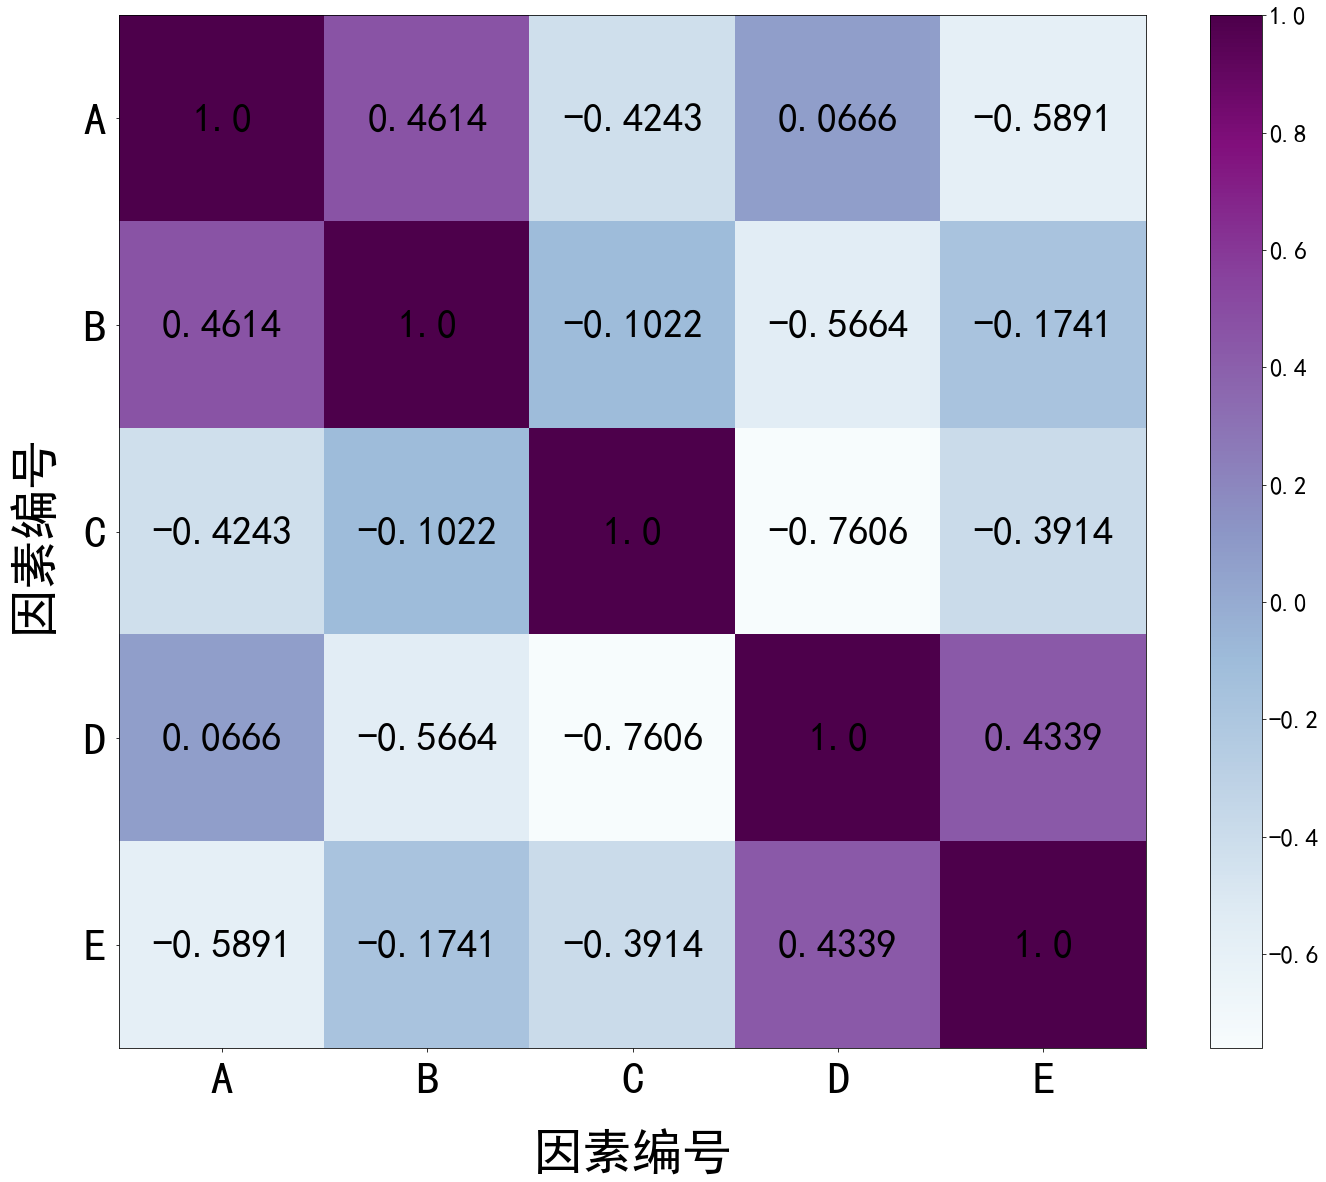

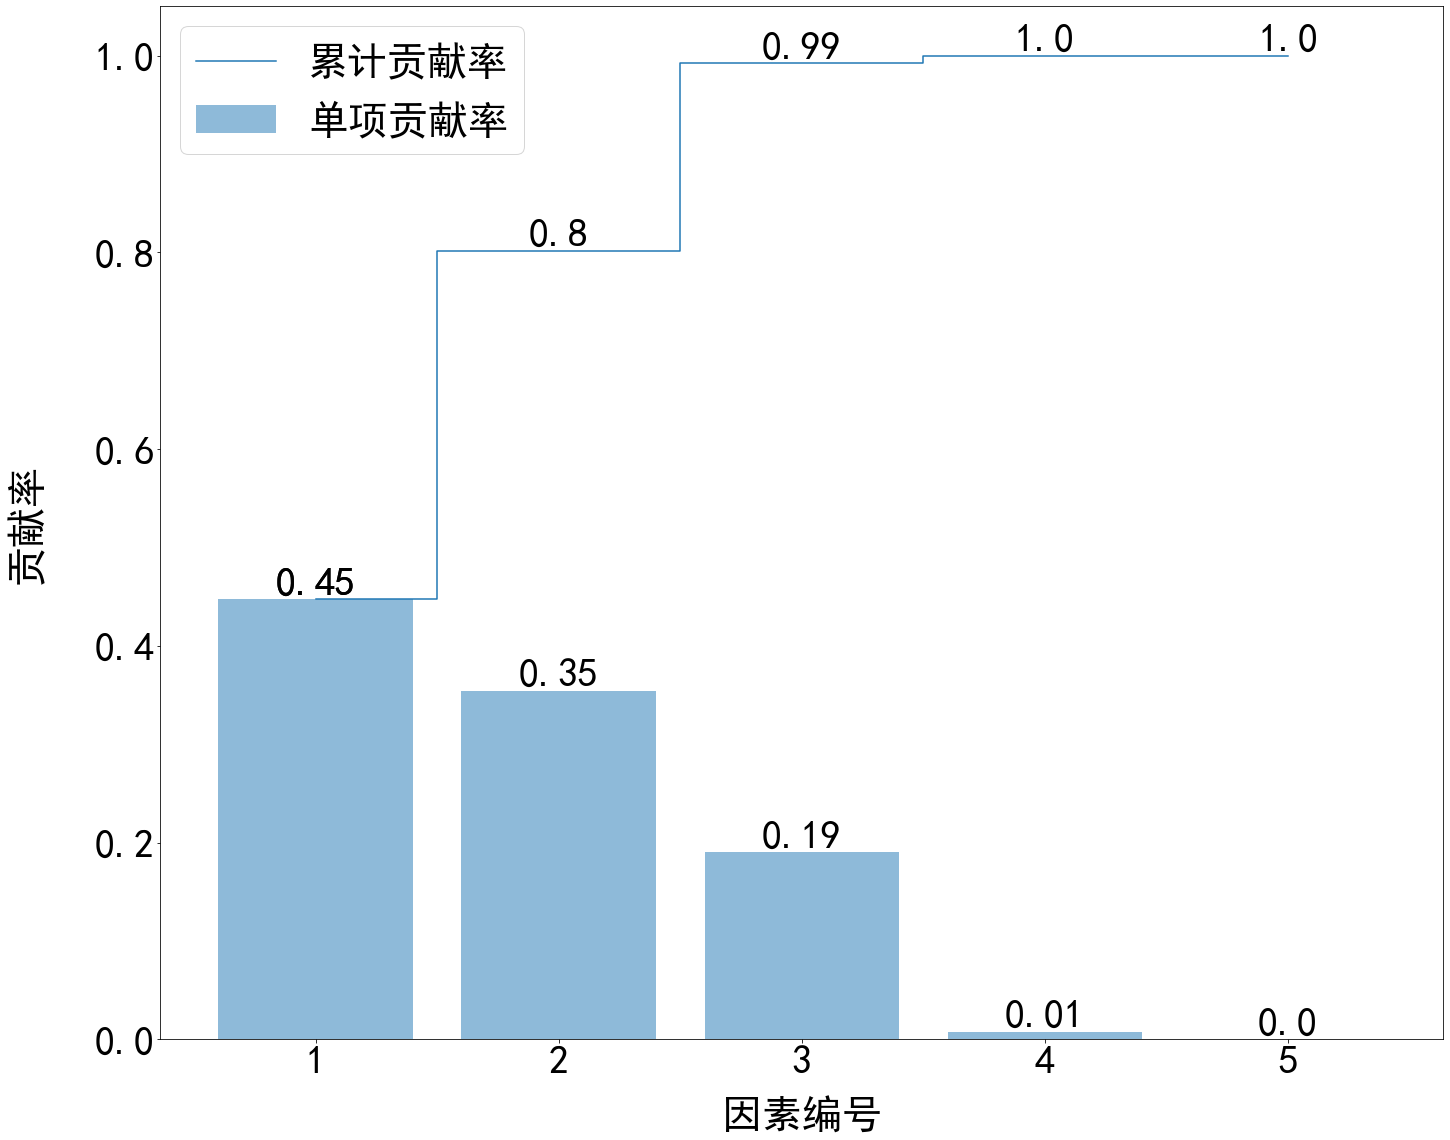

In [186]:
#X是矩阵数据，行为样本，列为维度，得出维度指标贡献率和降维结果
X = np.array([[1,2,3,4,5],[2,3,2,4,5],[2,4,5,2,3],[8,2,3,4,2],[0,2,9,1,3],[7,8,4,1,3]])

#画图
#plt.subplots(2, 1, figsize=(26,36), dpi=300)
pca_IndexNum(X = X,x_label = '因素编号',tag = ['A','B','C','D','E'])

In [188]:
#得出结果：行1-n代表指标，特征向量（m个列，前m个主成分）若在该位置绝对值高，则受了相关的影响，低的不好解释
vex,values = pca(X=X,k=2)
print("特征向量\n",vex)
print("新变量\n",values)

特征向量
 [[-0.10093895  0.40436199]
 [-0.44882698 -0.72414631]
 [-0.67109691  0.36882937]
 [ 0.52052342  0.12827597]
 [ 0.25894011 -0.39951681]]
新变量
 [[ 2.12799288  2.88600196]
 [ 0.54898978  3.00733293]
 [ 1.16300018 -1.01371183]
 [-4.15828509  1.40260897]
 [ 5.12697488 -3.11909101]
 [-4.80867263 -3.16314102]]


In [191]:
#其他
#主成分聚类：降维成两个指标
a = pd.DataFrame(values) #再保存到excel

In [193]:
#主成分消除多重共线性后进行回归